In [0]:
# Importing libraries
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('fivethirtyeight') 
# Above is a special style template for matplotlib, highly useful for visualizing time series data
%matplotlib inline

导入数据，并观察，发现很多冗余数据，最后只保留`'product_parent'`,`'review_date'`,`'value_score'`这几项

In [35]:
df = pd.read_csv('hd_value.csv',parse_dates=['review_date'])
df.head()

Unnamed: 0  product_parent  ...  sentiment  value_score
0           0       235105995  ...  -0.163889     0.233201
1           1       108191918  ...  -0.055556     0.211501
2           2       791081896  ...   0.222857     0.044641
3           3       199558933  ...   0.250000     0.300544
4           4       303775294  ...   0.508889     0.500864

[5 rows x 11 columns]

In [0]:
df = df[['product_parent','review_date','value_score']]

观察数字趋势，算出每三个月所有的评论次数，并绘制曲线。

In [37]:
df['review_date'].value_counts().sort_values().plot.line()
df['review_date'].value_counts().resample('3M').sum().plot.line()

按照评论顺序排序，为方便之后的处理。并算出mean_score，作为好评/差评的分界值。

In [0]:
df = df.sort_values('review_date')
mean_score = df['value_score'].mean()

对于某个特定的产品进行分析。


> 值得注意的是，满足特定条件的产品并不多，建议使用评论数量比较大的产品进行分析。


'758099411'为产品编号

In [0]:
product = pd.DataFrame(df[df['product_parent']==758099411])

算出时间跨度。

In [40]:
product['review_date'][100:].max()-product['review_date'][100:].min()

Timedelta('964 days 00:00:00')

# 使用牛顿冷却定律计算热度
这里的c取值为：
$$ c = \frac{\ln(heat\_begin)}{begin\_date - end\_date}$$
其中heat_begin自己设置为100。
在T+Δt时间的初始Heat值使用牛顿冷却定律计算，再加上由于新的评论引发的Heat。即：
$$H[T+Δt] = H[T]*exp(-c*Δt)+(value\_score-mean\_score)*100$$

此处的参考模型：http://www.ruanyifeng.com/blog/2012/03/ranking_algorithm_newton_s_law_of_cooling.html

In [0]:
c = np.log(100)/(product['review_date'][:].max()-product['review_date'][:].min()).days

In [42]:
heat = 100
product['heat'] = 0
product['heat'].iloc[0] = 100

for i in range(1,product.shape[0]):
  single = product.iloc[i]
  timeperiod = (product['review_date'].iloc[i]-product['review_date'].iloc[i-1]).days
  heat = product['heat'].iloc[i-1]*np.exp(-c*timeperiod) + (product['value_score']-mean_score).iloc[i-1]*100
  product['heat'].iloc[i] = heat
product

product_parent review_date  value_score        heat
1041        758099411  2008-11-08     0.609433  100.000000
1012        758099411  2009-01-10     0.469342   95.175774
1029        758099411  2009-03-07     0.676412   77.978639
583         758099411  2009-06-23     0.597119   76.729202
11102       758099411  2009-07-04     0.622818   80.137498
...               ...         ...          ...         ...
1722        758099411  2015-08-24     0.623151  545.180650
1714        758099411  2015-08-25     0.712291  551.730635
1713        758099411  2015-08-25     0.586075  568.203162
1700        758099411  2015-08-26     0.523291  571.002902
1662        758099411  2015-08-31     0.564560  563.313235

[535 rows x 4 columns]

某一天的热度 = 当天热度之和

In [0]:
timeseries = product.groupby('review_date').sum()
timeseries['count'] = product.groupby('review_date').count()['product_parent']

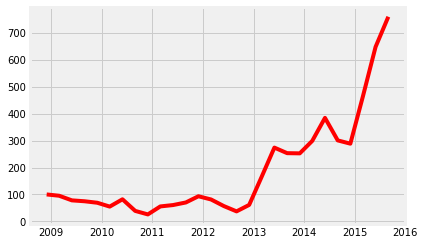

In [46]:
plt.plot(timeseries['heat'].resample('3M').mean(),c='red')
plt.savefig("Freecooling.png")

最后画出热度曲线。可以发现热度曲线和新增评论数目大部分吻合。

In [45]:
fig,ax1=plt.subplots() #subplots一定要带s
ax1.plot(product['review_date'].value_counts().resample('M').sum())
ax1.set_ylabel('Reviews every Month')
ax2=ax1.twinx() #twinx将ax1的X轴共用与ax2，这步很重要
ax2.plot(timeseries['heat'].resample('3M').mean(),c='red')
ax2.set_ylabel('Mean Heat every 3 Month')
plt.grid(False)
plt.show()